In [1]:
import sys,os,copy,glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
sys.path.append(os.path.abspath('../'))
from builder.protomodel import ProtoModel
from builder.manipulator import Manipulator
from tester.predictor import Predictor
from tester.combiner import Combiner
from walker.hiscore import Hiscore
from smodels.experiment.databaseObj import Database
from smodels.tools import runtime
from smodels.tools.physicsUnits import fb
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from names import particleLabels
from sparticleNames import SParticleNames
# sns.set() #Set style
# sns.set_style('ticks')
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
# sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("deep"))
from smodels.tools import smodelsLogging
smodelsLogging.setLogLevel('error')

In [2]:
#Set colors:
allPids = [1000022, 1000006, 1000001, 1000021, 1000012, 1000023, 
            1000013, 2000006, 1000011, 1000005, 1000014, 1000004, 1000015, 1000016, 1000024]
namer = SParticleNames ( susy = False )
colors = sns.color_palette('deep',n_colors=len(namer.xIDs))

#Replace default colors:
for pid in sorted(namer.xIDs.keys()):
    if not pid in allPids:
        allPids.append(pid)
colorDict = dict(zip(allPids,colors))
colorDict[1000002] = colorDict#             masses[pid].append(np.nan)[1000001]
colorDict[1000003] = colorDict[1000001]
colorDict[1000004] = colorDict[1000001]

In [3]:
def getLikelihoods(protomodel,muvals,normalize=True):
    
    #Sort tpList
    critic = sorted(protomodel.tpList, key = lambda tp: tp[0], reverse = True)[0][2]

    #Combiner likelihood:
    combiner = Combiner(0)
    llhComb = np.array([combiner.getCombinedLikelihood(protomodel.bestCombo,mu) for mu in muvals])
    llhCombSM = combiner.getCombinedLikelihood(protomodel.bestCombo,0.)
    llhDict = {'Combined' : llhComb}
    llhDictSM = {'Combined' : llhCombSM}
    for tp in protomodel.bestCombo:
        llhDict[tp.expResult.globalInfo.id] = np.array([tp.getLikelihood(mu) for mu in muvals])
        llhDictSM[tp.expResult.globalInfo.id] = tp.getLikelihood(0.0)

    #Critic likelihood:
    if critic.getLikelihood(1.0) is not None:
        llhDictSM['Critic'] = critic.getLikelihood(0.0)
        llhDict['Critic'] = np.array([critic.getLikelihood(mu) for mu in muvals])
    else:
        llhDict['Critic'] = None
        llhDictSM['Critic'] = None
    llhDict['SM values'] = llhDictSM
    
    #Compute normalizations:
    if normalize:
        for key,llhd in llhDict.items():
            if key != 'SM values':
                norm = llhd.sum()
                llhDict[key] = llhd/norm
                llhDict['SM values'][key] *= 1/norm
    
    
    return llhDict


In [4]:
def fromDict(inputDict):
    
    p = ProtoModel(walkerid=0)
    for key,v in inputDict.items():
        setattr(p,key,copy.deepcopy(v))
        
    return p

In [5]:
#Get highest score from each run:
protomodelsDict = {}
for ff in glob.glob('../data/real*.dict'):
    with open(ff,'r') as f:
        pList = eval(f.read())
    run = eval(os.path.basename(ff).replace('real','').replace('.dict',''))
    pList = [fromDict(pDict) for pDict in pList[:]]
    p = sorted(pList, key = lambda p: p.K, reverse=True)[0]
    protomodelsDict[run] = p  

In [6]:
for run in sorted(protomodelsDict.keys()):
    print(run,protomodelsDict[run])
    
Kavg = np.array([p.K for p in protomodelsDict.values()]).mean()
Kstd = np.array([p.K for p in protomodelsDict.values()]).std()
print('K (avg) = %1.2f +- %1.2f' %(Kavg,Kstd))

1 ProtoModel (XZ1,Xd,Xt): K = 6.74, Z = 3.21
2 ProtoModel (XZ1,Xd,Xt): K = 6.79, Z = 3.22
3 ProtoModel (XZ1,Xt,Xc): K = 6.87, Z = 3.23
4 ProtoModel (XZ1,Xd,Xt): K = 6.70, Z = 3.20
5 ProtoModel (XZ1,Xd,Xt,Xmu): K = 6.76, Z = 3.47
6 ProtoModel (XZ1,Xt,Xd): K = 6.77, Z = 3.21
7 ProtoModel (XZ1,Xt,Xc): K = 6.58, Z = 3.18
8 ProtoModel (XZ1,Xt,Xd): K = 6.79, Z = 3.21
9 ProtoModel (XZ1,Xd,Xt): K = 6.90, Z = 3.24
10 ProtoModel (XZ1,Xt,Xd): K = 6.73, Z = 3.21
K (avg) = 6.76 +- 0.08


In [7]:
#Get all particles which appears in all models:
particles = []
modelList = np.array(list(protomodelsDict.items()))
runs = modelList[:,0]
modelList = modelList[:,1]
for p in modelList:
    particles += p.unFrozenParticles()
particles = list(set(particles))

#Build useful dataset:
nparticles = np.array([len(p.unFrozenParticles()) for p in modelList])
Kvalues = np.array([p.K if (p.K and p.K > 0) else 0.0 for p in modelList])
Zvalues = np.array([p.Z if (p.Z and p.Z > 0) else 0.0 for p in modelList])
masses = dict([[pid,[]] for pid in particles])
for p in modelList:
    for pid in masses:
        if pid in p.masses:
            masses[pid].append(p.masses[pid])
        else:
            masses[pid].append(-100.0)
for pid in masses:
    masses[pid] = np.array(masses[pid])
dataDict = {'run' : runs, 'K' : Kvalues,
                   'nparticles' : nparticles}
dataDict.update(masses) 
df = pd.DataFrame(dataDict)

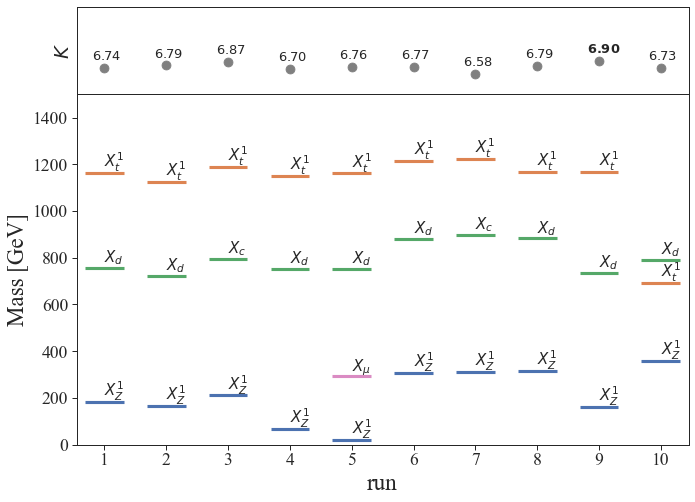

In [8]:
f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[1, 4]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0)

nsteps = 10

pids = sorted(list(masses.keys()))

axarr[0].scatter(df['run'],df['K'],s=80,c='gray')
axarr[0].set_ylabel(r'$K$')
axarr[0].set_ylim(6.1,8.2)
axarr[0].set_yticks([])
for i,row in df.iterrows():
    if row['K'] == max(df['K']):
        axarr[0].annotate(r'$\mathbf{%1.2f}$' %row['K'],(row['run']-0.2,row['K']+0.2),
                          fontsize=13)
    else:
        axarr[0].annotate(r'$%1.2f$' %row['K'],(row['run']-0.2,row['K']+0.2),fontsize=13)



for pid in pids:    
    data = df
    sns.scatterplot(x=data['run'],y=data[pid], size=1000,sizes=(1500,1500),marker='_',
                    label=r'$%s$' %(particleLabels[pid]), legend=False,
                    c=[colorDict[pid]],ax=axarr[1])
    for i,m in enumerate(masses[pid]):
        if m < 0: continue
        axarr[1].annotate(r'$%s$' %(particleLabels[pid]),(runs[i],m+25.),fontsize=15)
axarr[1].set_ylim(0.,1500.0)
axarr[1].set_xlabel('run', fontsize=23)
axarr[1].set_ylabel('Mass [GeV]', fontsize=23)
axarr[1].set_xticks(sorted(df['run'].tolist()))
plt.savefig('highScore_massesv1.pdf')
plt.show()